In [20]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [21]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [23]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
# explore and understand the data

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within each table and its types
for table in tables:
    print(table)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])
        
    print()

measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [25]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [26]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [27]:
# Create a session
session = Session(engine)

In [28]:
# get most recent date
query = "SELECT max(date) from measurement;"

data = engine.execute(text(query)).all()
data

[('2017-08-23',)]

In [29]:
session.query(func.max(Measurement.date)).all()

[('2017-08-23',)]

In [30]:
data = session.query(Measurement.date, Measurement.station, Measurement.prcp).where(Measurement.date >= '2016-08-23').all()
df2 = pd.DataFrame(data, columns=["date", "station", "prcp"])

df2.head()

,date,station,prcp
0,2016-08-23,USC00519397,0.00
1,2016-08-24,USC00519397,0.08
2,2016-08-25,USC00519397,0.08
3,2016-08-26,USC00519397,0.00
4,2016-08-27,USC00519397,0.00


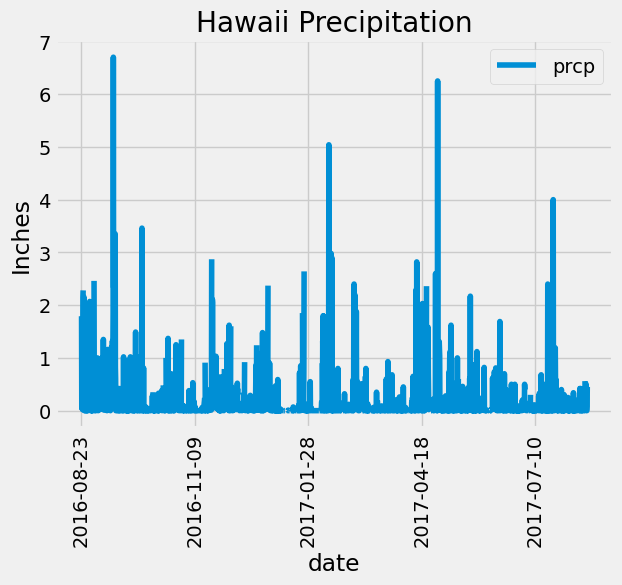

In [31]:
df2 = df2.sort_values(by="date")

df2.plot(kind="line", x="date", y="prcp", title="Hawaii Precipitation", ylabel="Inches", rot=90)
plt.show()

In [32]:
df2.prcp.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [33]:
# Design a query to calculate the total number of stations in the dataset
query = "SELECT count(id) from station;"

data = engine.execute(text(query)).all()
data

[(9,)]

In [34]:
session.query(func.count(Station.id)).all()

[(9,)]

In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query = """SELECT
                station,
                count(id) as num_obs
            FROM
                measurement
            GROUP BY
                station
            ORDER BY
                num_obs desc;
"""

df2 = pd.read_sql(text(query), con=engine)
df2.head(10)

,station,num_obs
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [35]:
session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
query = """
        SELECT
            min(tobs),
            max(tobs),
            avg(tobs)
        FROM
            measurement
        WHERE
            station = 'USC00519281'
"""

df3 = pd.read_sql(text(query), con=engine)
df3 

,min(tobs),max(tobs),avg(tobs)
0,54.0,85.0,71.663781


In [37]:
data = engine.execute(text(query)).all()
data

[(54.0, 85.0, 71.66378066378067)]

In [38]:
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = """SELECT
                date,
                station,
                tobs
            FROM
                measurement
            WHERE
                date >= '2016-08-23'
                AND station = 'USC00519281'
            ORDER BY
                date asc;
"""

df = pd.read_sql(text(query), con=engine)
df.head()

,date,station,tobs
0,2016-08-23,USC00519281,77.0
1,2016-08-24,USC00519281,77.0
2,2016-08-25,USC00519281,80.0
3,2016-08-26,USC00519281,80.0
4,2016-08-27,USC00519281,75.0


In [40]:
data = session.query(Measurement.date, Measurement.station, Measurement.tobs).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281').order_by(Measurement.date).all()

df2 = pd.DataFrame(data, columns=["date", "station", "tobs"])

df2.head()

,date,station,tobs
0,2016-08-23,USC00519281,77.0
1,2016-08-24,USC00519281,77.0
2,2016-08-25,USC00519281,80.0
3,2016-08-26,USC00519281,80.0
4,2016-08-27,USC00519281,75.0


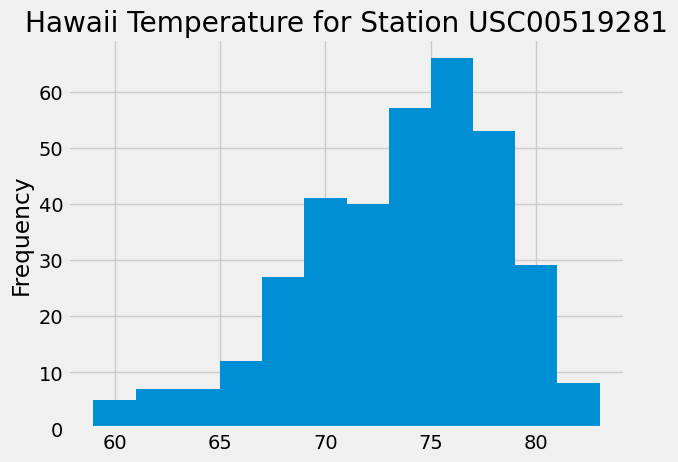

In [41]:
df2.tobs.plot.hist(bins=12, title="Hawaii Temperature for Station USC00519281", ylabel="Frequency")
plt.show()

In [ ]:
# Close Session
session.close()